## Visualize Distributions of TMC data

### Dependencies

In [6]:
import glob
import numpy as np
import os
import collections
import sys

import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

import csv
import seaborn as sns
from matplotlib_venn import venn3

import argparse
import yaml

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [9]:
root_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files'
processed_data_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData'
raw_data_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/Data'
gt_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData/gt.pkl'
result_path = '/project/ahoover/mhealth/zeyut/tmc/results/'
# result_path = './results/'


Label2Numbers = {'Healthy': 0, 'Mid-Stage': 1, 'Late-Stage': 2}
Numbers2Labels = {0: 'Healthy', 1: 'Mid-Stage', 2: 'Late-Stage'}

gesture_list = ['Key Pinch', 'Stat Abd', 'Stat Add', 'Stat Ext', 'Stat Flex']


In [10]:
font = {'weight' : 'normal','size': 21}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

### Load data

#### Ground truth files

In [60]:
grades = {}
ages = {}

grades['new'] = {}
grades['old'] = {}
# Load new scores
grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/Hand Groups.xlsx'))
sample_codes = (grade_df.iloc[:, 0].tolist())
for sc in sample_codes:
    group = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 1]
    grades['new'][sc] = Label2Numbers[group]
# Load old OA scores
old_grades = {}
grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/all_results_clean_for_stats.xlsx'))
for sc in sample_codes:
    try:
        grades['old'][sc] = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 2]
        ages[sc] = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == sc][0], 1]
    except:
        print(f'Cannot find old grade for {sc}')
        del grades['new'][sc]
    

Cannot find old grade for H37


In [61]:
print(f'class size')
class_sizes_old = [collections.Counter(list(grades['old'].values())).get(i, 0) for i in range(5)]
class_sizes_new = [collections.Counter(list(grades['new'].values())).get(i, 0) for i in range(3)]
print(f"old_grades: {class_sizes_old}")
print(f"new_grades: {class_sizes_new}")

class size
old_grades: [7, 14, 15, 7, 3]
new_grades: [23, 10, 13]


In [62]:
stat_df = pd.DataFrame({
    'Age': [ages[sc] for sc in grades['new'] if sc in ages],
    'new grades': [Numbers2Labels[label] for label in list(grades['new'].values())],
    'old grades': [label for label in list(grades['old'].values())]

})

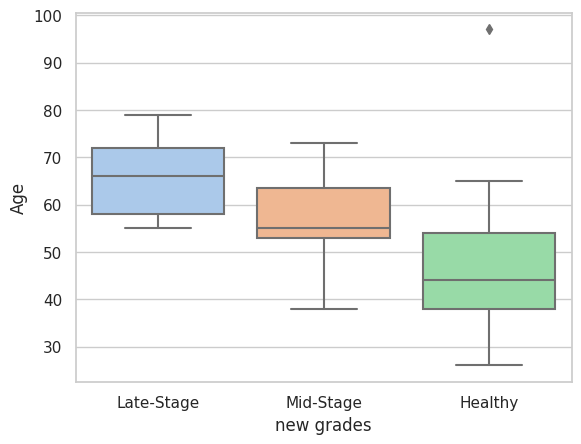

In [63]:
sns.boxplot(data=stat_df, x='new grades', y='Age', palette='pastel')
# plt.title('Age Distribution Across Health Categories')
plt.show()

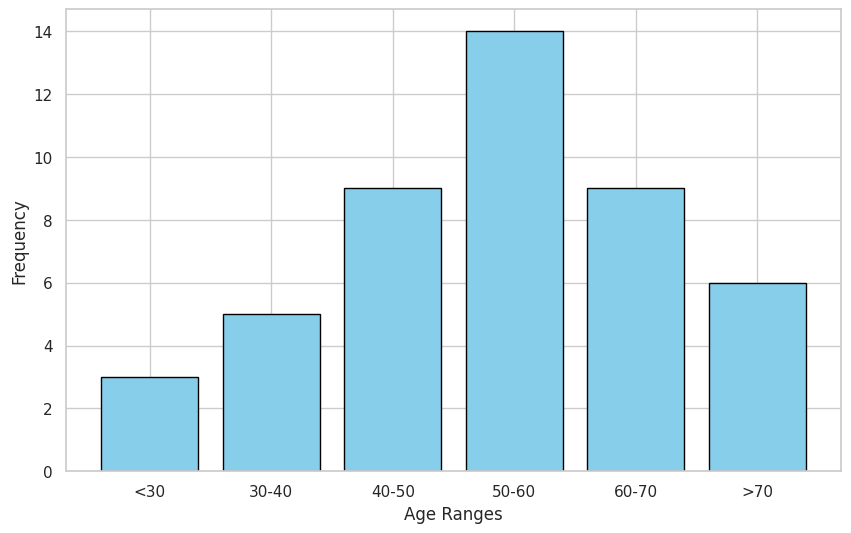

In [64]:
# Create a histogram of ages
age_distribution = []
pre = 0
for t in [30, 40, 50, 60, 70]:
    cur = np.sum(stat_df['Age']<t)
    age_distribution.append(cur-pre)
    pre = cur
age_distribution.append(np.sum(stat_df['Age']>70))
bin_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '>70']
positions = range(len(age_distribution))

# Setting seaborn style
sns.set(style="whitegrid")

# Same plotting code as the matplotlib example
plt.figure(figsize=(10, 6))
plt.bar(positions, age_distribution, color='skyblue', edgecolor='black')
plt.xticks(positions, bin_labels)

# plt.title('Histogram of Ages')
plt.xlabel('Age Ranges')
plt.ylabel('Frequency')
plt.savefig('age_histogram.jpg', dpi=300)
plt.show()


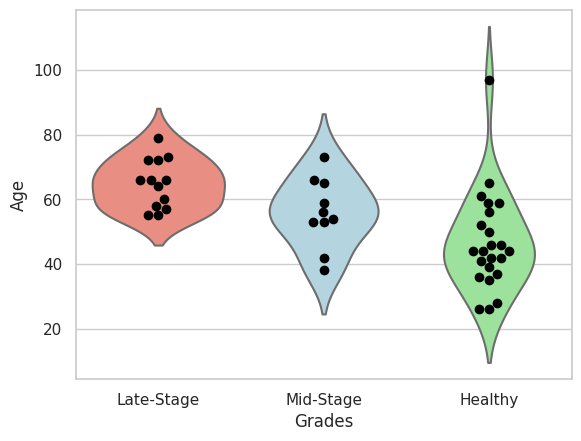

In [110]:
# Create a swarm plot
# Define a color palette
palette = {
    'Healthy': 'lightgreen',
    'Mid-Stage': 'lightblue',
    'Late-Stage': 'salmon'
}

sns.swarmplot(data=stat_df, x='new grades', y='Age', size=7, color='black')
sns.violinplot(data=stat_df, x='new grades', y='Age', palette=palette, inner=None, edgecolor='gray')
# plt.title('Detailed Distribution of Age and Health Category')
plt.xlabel('Grades')
plt.savefig('age_vs_new_grades.jpg', dpi=300)
plt.show()

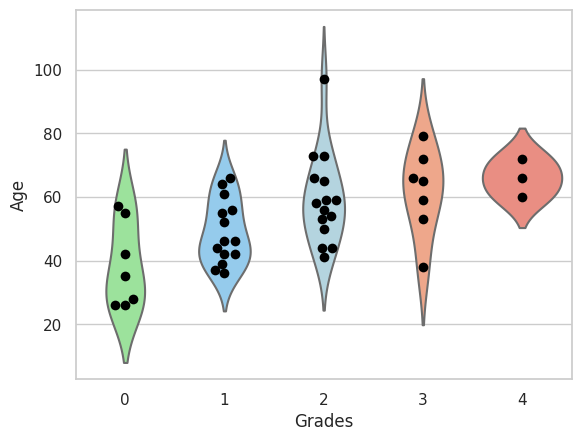

In [111]:
# Create a swarm plot
# Define a color palette
palette = {
    0: '#90EE90',
    1: '#87CEFA',
    2: '#ADD8E6',
    3: '#FFA07A',
    4: 'salmon',
}

sns.swarmplot(data=stat_df, x='old grades', y='Age', size=7, color='black')
sns.violinplot(data=stat_df, x='old grades', y='Age', palette=palette, inner=None, edgecolor='gray')
# plt.title('Detailed Distribution of Age and Health Category')
plt.xlabel('Grades')
plt.savefig('age_vs_old_grades.jpg', dpi=300)
plt.show()

In [112]:

with open(os.path.join(processed_data_path, 'static_data.pkl'), 'rb') as file:
    static_data = pickle.load(file)
static_sc = set(list(static_data.keys()))
static_sc.discard('H37')
with open(os.path.join(processed_data_path, 'kinematic_data.pkl'), 'rb') as file:
    kinematic_data = pickle.load(file)
kinematic_sc = set(list(kinematic_data.keys()))
kinematic_sc.discard('H37')

image_sc = set([filename[:-4] for filename in os.listdir(os.path.join(processed_data_path, 'images'))])
image_sc.discard('H37')


In [113]:
overlap_ks

set()

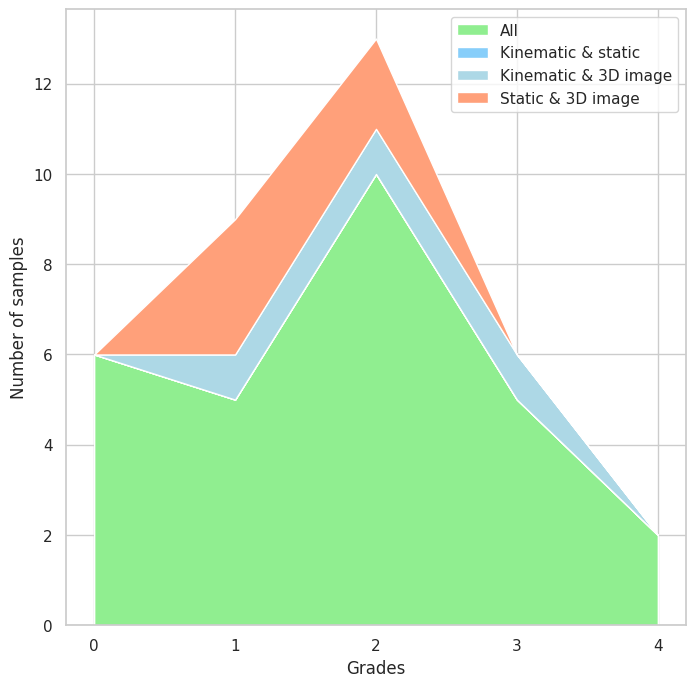

In [114]:
overlap_ks = kinematic_sc & static_sc - image_sc
overlap_ki = kinematic_sc & image_sc - static_sc
overlap_si = static_sc & image_sc - kinematic_sc
overlap_ksi = kinematic_sc & static_sc & image_sc

x = np.arange(5)
y_ksi = np.bincount([grades['old'][sc] for sc in list(overlap_ksi)], minlength=5)
y_ks = np.bincount([grades['old'][sc] for sc in list(overlap_ks)], minlength=5)
y_ki = np.bincount([grades['old'][sc] for sc in list(overlap_ki)], minlength=5)
y_si = np.bincount([grades['old'][sc] for sc in list(overlap_si)], minlength=5)

fig, ax = plt.subplots(figsize=(8, 8))
ax.stackplot(x, y_ksi, y_ks, y_ki, y_si, 
             labels=['All', 'Kinematic & static', 'Kinematic & 3D image', 'Static & 3D image'], 
             colors=['#90EE90','#87CEFA','#ADD8E6','#FFA07A'])
ax.legend(loc='upper right')

plt.xticks(x, np.arange(5))
plt.xlabel('Grades')
plt.ylabel('Number of samples')
plt.savefig('samples_vs_modality_old.jpg', dpi=300)

plt.show()


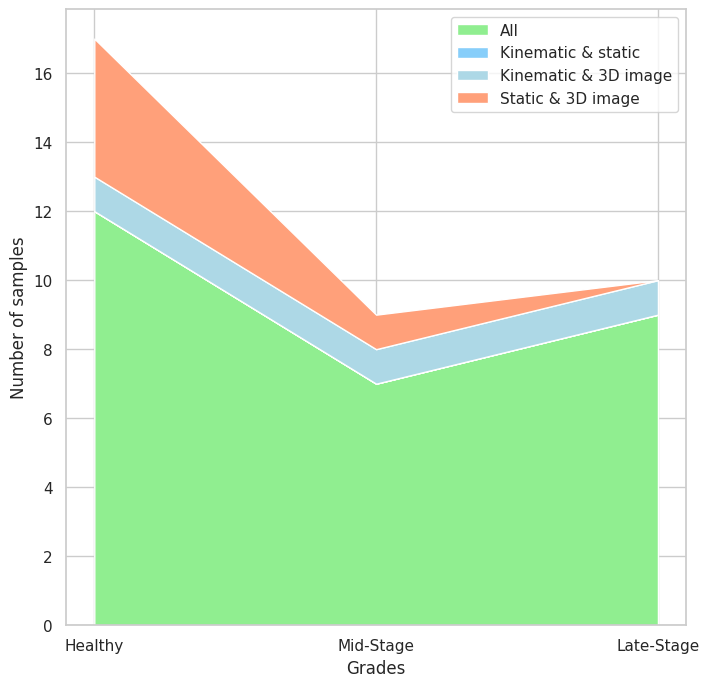

In [115]:
x = np.arange(3)
y_ksi = np.bincount([grades['new'][sc] for sc in list(overlap_ksi)], minlength=3)
y_ks = np.bincount([grades['new'][sc] for sc in list(overlap_ks)], minlength=3)
y_ki = np.bincount([grades['new'][sc] for sc in list(overlap_ki)], minlength=3)
y_si = np.bincount([grades['new'][sc] for sc in list(overlap_si)], minlength=3)

fig, ax = plt.subplots(figsize=(8, 8))
ax.stackplot(x, y_ksi, y_ks, y_ki, y_si, 
             labels=['All', 'Kinematic & static', 'Kinematic & 3D image', 'Static & 3D image'], 
             colors=['#90EE90','#87CEFA','#ADD8E6','#FFA07A'])
ax.legend(loc='upper right')

plt.xticks(x, ['Healthy', 'Mid-Stage', 'Late-Stage'])
plt.xlabel('Grades')
plt.ylabel('Number of samples')
plt.savefig('samples_vs_modality_new.jpg', dpi=300)

plt.show()


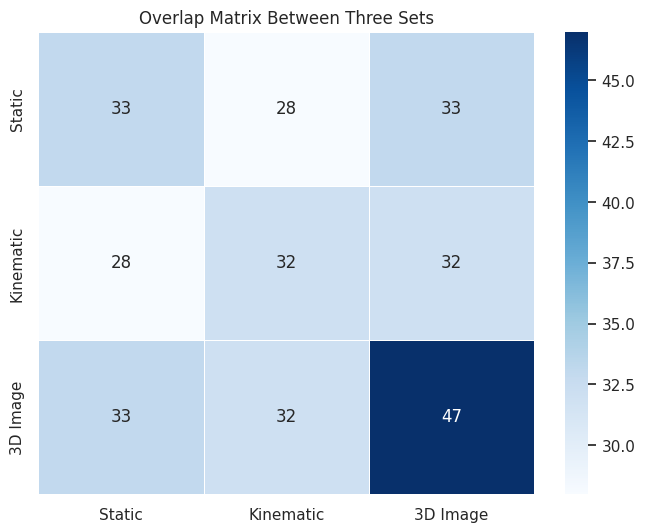

In [38]:
# Calculate intersections
overlap_ks = len(kinematic_sc & static_sc)
overlap_ki = len(kinematic_sc & image_sc)
overlap_si = len(static_sc & image_sc)
overlap_ksi = len(kinematic_sc & static_sc & image_sc)

# Create a DataFrame to represent the overlaps
overlap_data = pd.DataFrame({
    'Static': [len(static_sc), overlap_ks, overlap_si],
    'Kinematic': [overlap_ks, len(kinematic_sc), overlap_ki],
    '3D Image': [overlap_si, overlap_ki, len(image_sc)]
}, index=['Static', 'Kinematic', '3D Image'])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(overlap_data, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Number of available subjects Between Three data modalities')
plt.show()


In [6]:
if not os.path.exists(gt_path):
    with open(gt_path, 'wb') as file:
        pickle.dump(grades, file)

#### Processed kinematic data
* Calculated from motion and rigid body data 
* Processing script: kinematic_multiprocessing.py (Edited on 11/2024 by Daniel Gordon)
* subject H7, H8, H16, J2, J4, J8, J9 do not have kinematic data

In [31]:
raw_pkl_path = os.path.join(processed_data_path, 'kinematic_raw.pkl')
if os.path.exists(raw_pkl_path):
    with open(raw_pkl_path, 'rb') as file:
        kinematic_raw = pickle.load(file)
else:
    # Load raw data
    kinematic_raw = collections.defaultdict(dict)
    for sc in sample_codes:
        cur_path = os.path.join(root_path, f'ProcessingScripts/Results/{sc} Kinematic Results.xlsx')
        try:
            kinematic_sheets = pd.read_excel(cur_path, sheet_name=None)
            for sheet_name in kinematic_sheets.keys():
                gesture = sheet_name.split(sc)[1].strip()
                raw = kinematic_sheets[sheet_name].values
                kinematic_raw[sc][gesture] = kinematic_sheets[sheet_name].values
        except:
            print(f'Can not open {sc} kinematic result file')

    # Save data to pkl file to reduce loading time
    with open(raw_pkl_path, 'wb') as file:
        pickle.dump(kinematic_raw, file)

In [32]:
# Load start/end timestamps for each cycle 
cycles = collections.defaultdict(dict)
all_cycle_sheets = pd.read_excel(os.path.join(root_path, f'Supplements/Kinematic Cycles.xlsx'), sheet_name=None)
for sc in kinematic_raw:
    try:
        cycle_df = all_cycle_sheets[sc]
        for _, row in cycle_df.iterrows():
            gesture = row.iloc[0]
            cur_cycles = []
            for i, value in enumerate(row[1:]):  # skipping index
                if not pd.isna(value):
                    start_idx, end_idx = value.split(':')
                    cur_cycles.append([int(start_idx.strip()), int(end_idx.strip())])
            if cur_cycles:
                cycles[sc][gesture] = cur_cycles
    except:
        print(f'Can not find cycle info for {sc}')

# Remove those subjects that do not have all five gestures 
for sc in list(cycles.keys()):
    if len(cycles[sc]) != 5:
        print(sc)
        del cycles[sc]

H15
H19
H26
J5
J7


In [33]:
# Count maximum cycle length for each gesture
print('Max cycle length')
for sc in cycles:
    print(sc)
    all_lens = []
    for gesture in gesture_list:
        lens = [end-start for start, end in cycles[sc][gesture]]
        # print(f"{gesture} max: {np.max(lens)} avg: {np.mean(lens):.02f} cycle len: {lens}")    
    
        all_lens.append(max([end-start for start, end in cycles[sc][gesture]]))
    print(f'max cycle length per gesture: {all_lens}')

Max cycle length
H1
max cycle length per gesture: [793, 671, 740, 695, 1157]
H3
max cycle length per gesture: [327, 330, 224, 209, 246]
H4
max cycle length per gesture: [7372, 6921, 6629, 6921, 8679]
H5
max cycle length per gesture: [10320, 8391, 8280, 8885, 11332]
H9
max cycle length per gesture: [9264, 7816, 8011, 8317, 7113]
H10
max cycle length per gesture: [10547, 8189, 8306, 8312, 11432]
H11
max cycle length per gesture: [9398, 7509, 9157, 9115, 9520]
H12
max cycle length per gesture: [9246, 8640, 8000, 8607, 8518]
H13
max cycle length per gesture: [11429, 8117, 8234, 8120, 10721]
H14
max cycle length per gesture: [308, 384, 229, 376, 501]
H18
max cycle length per gesture: [7901, 8943, 7144, 7157, 9494]
H20
max cycle length per gesture: [352, 465, 468, 301, 473]
H21
max cycle length per gesture: [414, 382, 406, 388, 469]
H22
max cycle length per gesture: [219, 349, 301, 319, 382]
H23
max cycle length per gesture: [255, 324, 233, 181, 270]
H24
max cycle length per gesture: [283, 4

In [34]:
# Slice data within each cycle and save to files
kinematic_data = collections.defaultdict(dict)
for sc in kinematic_raw:
    if sc not in cycles:
        continue
    for gesture in kinematic_raw[sc]:
        if gesture not in cycles[sc]:
            continue
        data = kinematic_raw[sc][gesture]
        kinematic_data[sc][gesture] = []
        for start_idx, end_idx in cycles[sc][gesture]:
            kinematic_data[sc][gesture].append(data[start_idx: end_idx])

if not os.path.exists(os.path.join(processed_data_path, 'kinematic_data.pkl')):
    with open(os.path.join(processed_data_path, 'kinematic_data.pkl'), 'wb') as file:
        pickle.dump(kinematic_data, file)



Key Pinch
Stat Abd
Stat Add
Stat Ext
Stat Flex


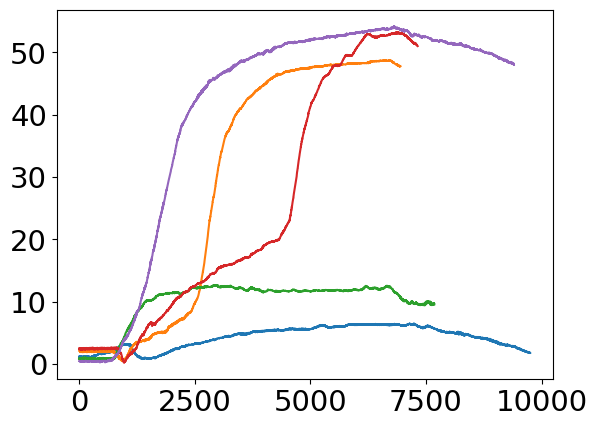

In [35]:
sc = 'J3'
for gesture in gesture_list:
    print(gesture)
    plt.plot(kinematic_data[sc][gesture][0][:, 0])

In [36]:
mean = []
std = []
for gesture in gesture_list:
    mean.append(np.mean(np.vstack([np.vstack(v[gesture]) for v in kinematic_data.values()]),axis=0))
    std.append(np.std(np.vstack([np.vstack(v[gesture]) for v in kinematic_data.values()]),axis=0))

In [37]:
std

[array([ 24.68050667,   2.05542705, 120.92328777,   8.51206906,
          9.83697987,   9.26287387,  80.49430528,   9.4006945 ]),
 array([ 24.4570863 ,   2.57981505, 120.58480345,   4.04779858,
         16.08127936,   4.50588822,  75.02620711,  13.06893166]),
 array([ 20.95788073,   3.05498723, 116.50273351,   6.41242108,
         13.56749622,   6.43618958,  82.77430517,  11.42619864]),
 array([ 29.77843322,   5.54253412, 114.86867905,  15.63156633,
         21.9643887 ,  10.95828284,  89.98362301,  14.74653418]),
 array([ 28.58102941,   7.16316   , 111.17806371,  12.84539873,
         30.91876887,  13.80616513,  67.59780561,  19.47213079])]

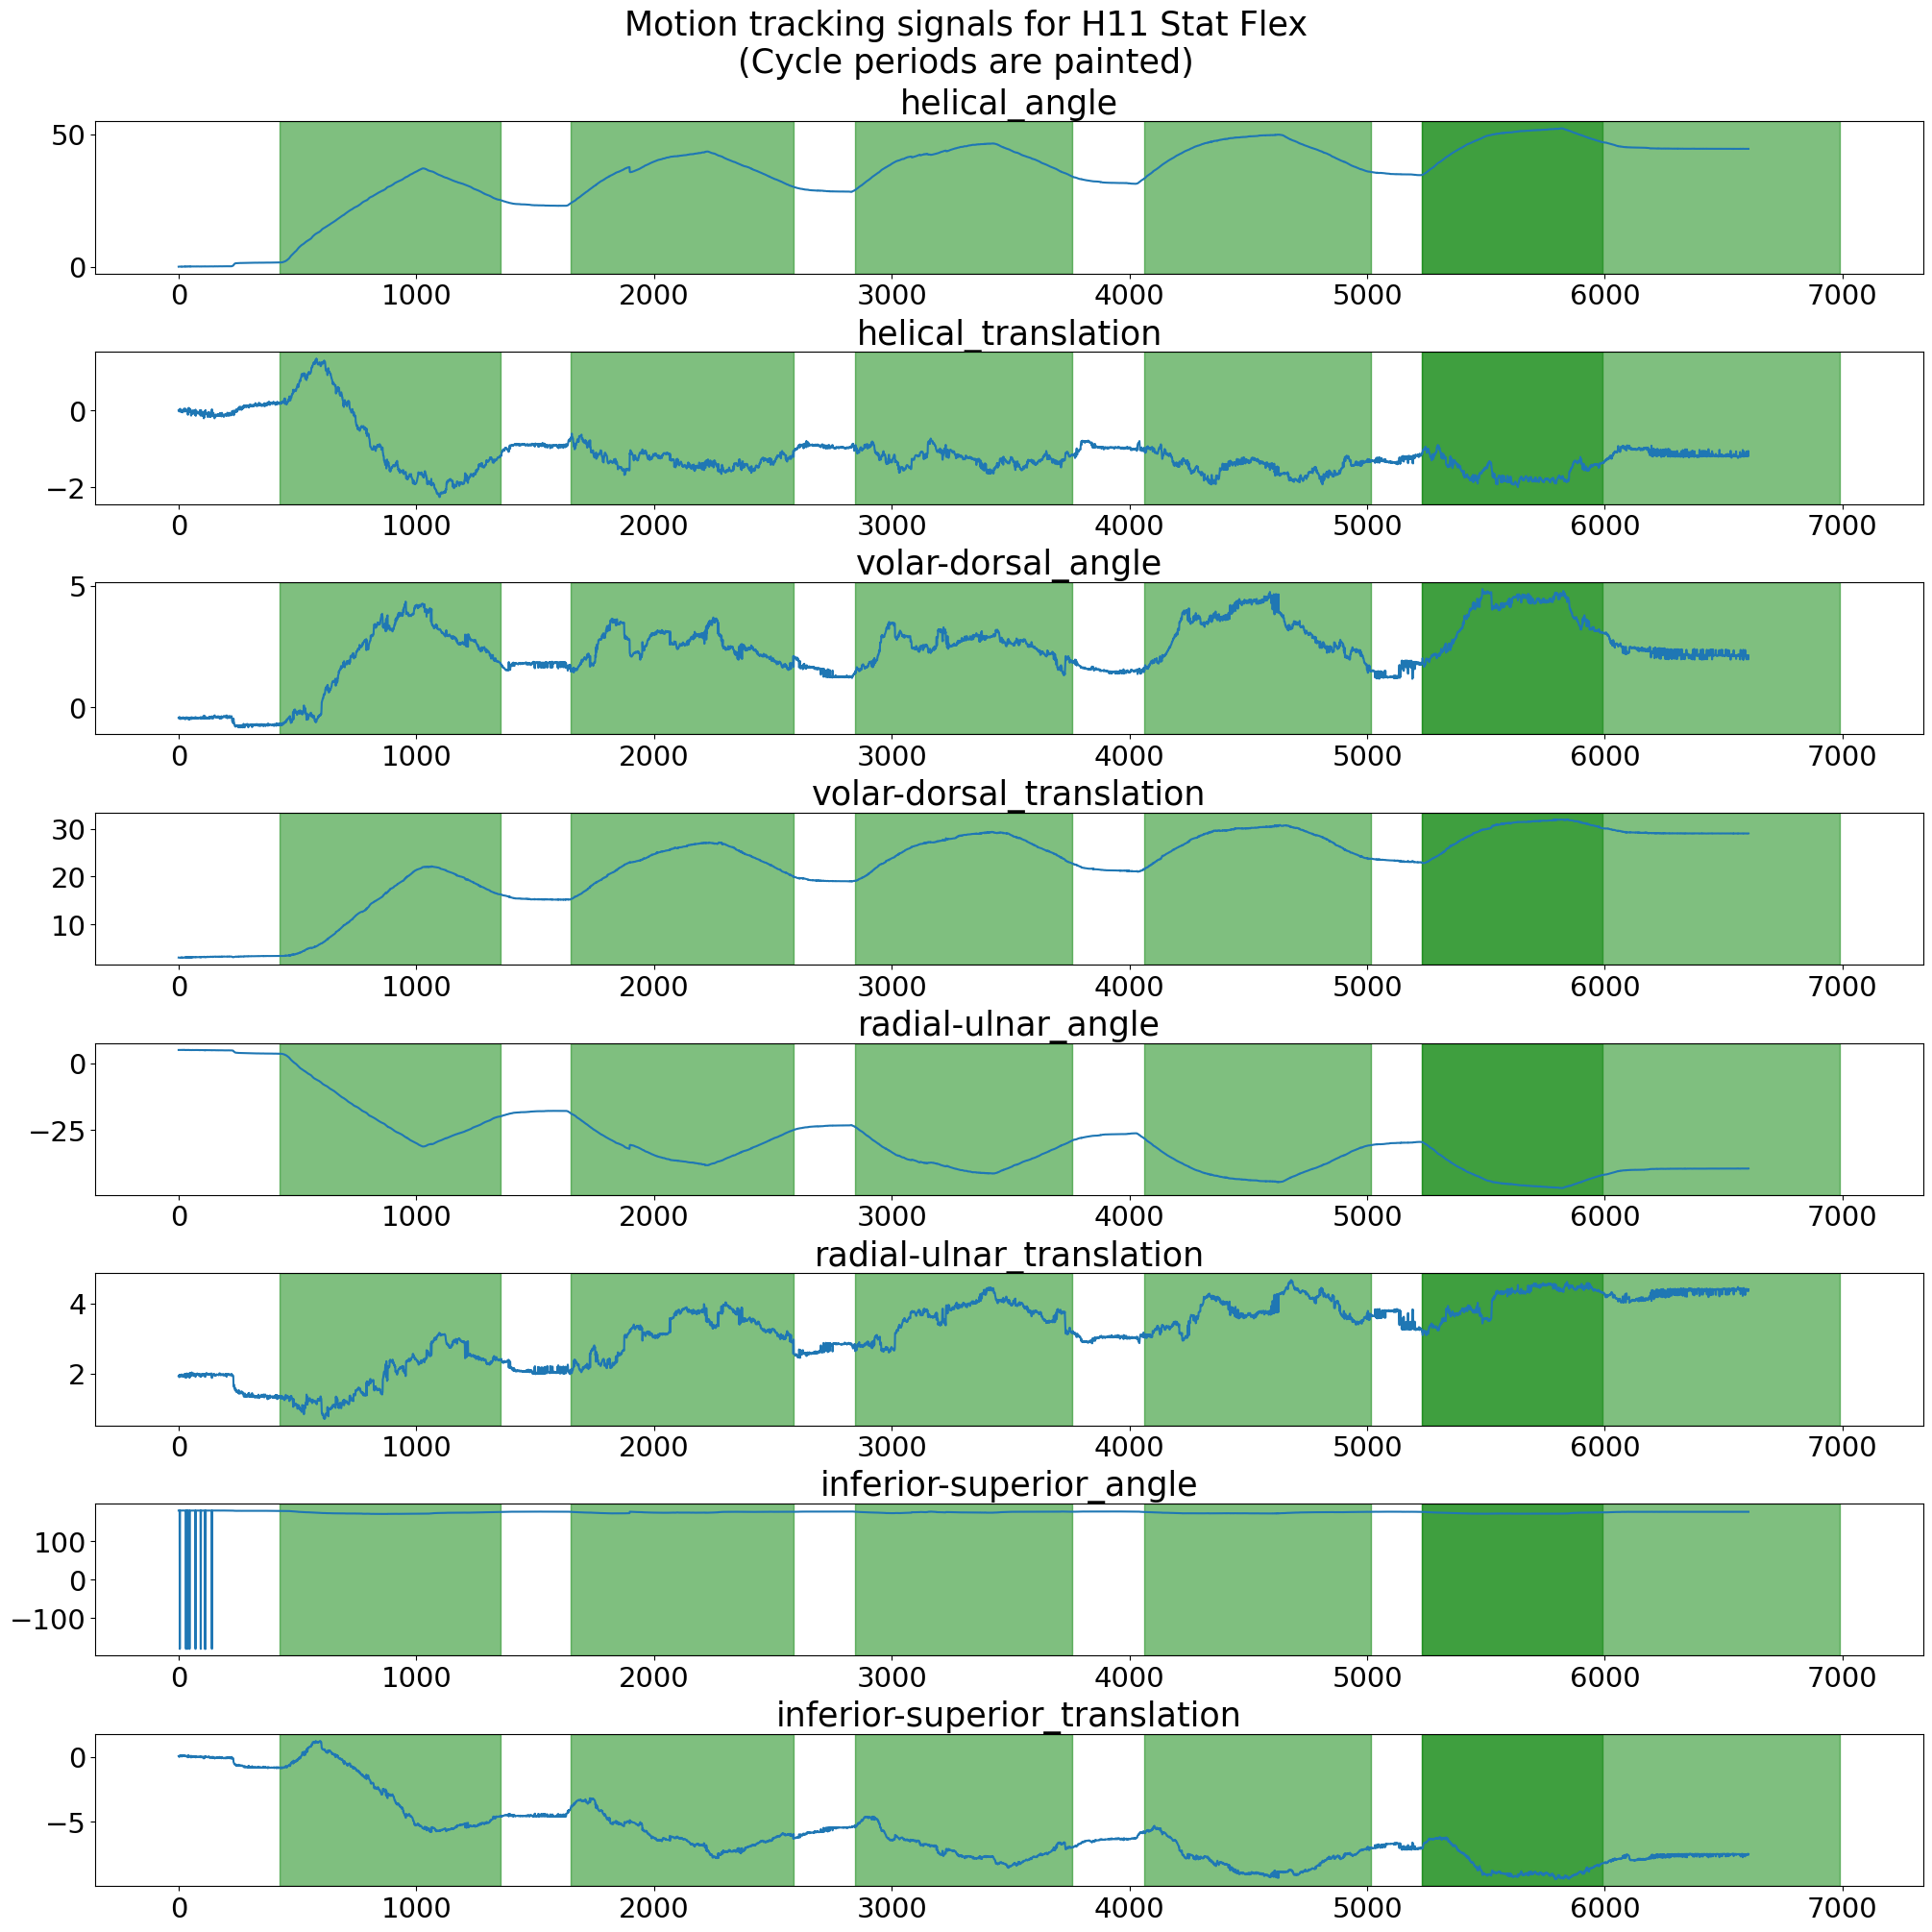

In [56]:
# Visualize data 
sc = 'H11'
gesture = 'Stat Flex'
downsample_rate = 10
fig, axs = plt.subplots(8, 1, 
                        figsize=(20, 20),
                        constrained_layout=True)
for i in range(8):
    axs[i].plot(kinematic_raw[sc][gesture][::downsample_rate, i])
    axs[i].set_title(kinematic_channels[i])
    for start_idx, end_idx in cycles[sc][gesture]:
        axs[i].axvspan(start_idx//downsample_rate, end_idx//downsample_rate, color='g', alpha=0.5, label='cycles')
    axs[i].axvspan(start_idx//downsample_rate, (end_idx+10000)//downsample_rate, color='g', alpha=0.5, label='cycles')
fig.suptitle(f'Motion tracking signals for {sc} {gesture}\n(Cycle periods are painted)')    
plt.show()
fig.savefig('time_series.jpg', dpi=600)

#### Static data 
* Include kinematic indices from motion tracking data and mechanical/dimensional measurements
* Select sample codes which have data available on all types

In [13]:
static_data = collections.defaultdict(list)

'''
Data drieved from dynamic measurement
    File: all_results_clean_for_stats.xlsx 
    Use sheet 'bony' and 'kinm', sheet 'mech' has many empty cells.

'''
static_sheets = pd.read_excel(os.path.join(root_path, f'Supplements/all_results_clean_for_stats.xlsx'), sheet_name=None)
for sheet_name in ['bony', 'kinm']:
    static_df = static_sheets[sheet_name]
    n_rows = len(static_df.iloc[0])
    static_df.dropna(thresh=n_rows//2, inplace=True) # Drop rows with more than half cells being nan
    sc_list = static_df.iloc[:, 0].values
    static_df = static_df.drop(columns=static_df.columns[:7]) # Leave numeric data only
    static_df.fillna(static_df.mean(), inplace=True) # Fill empty values with column average
    for sc, data in zip(sc_list, static_df.values):
        static_data[sc].append(data)

In [14]:
'''
Data drieved from mechanical measurement
    File: Ligament_Dimensions_Squash.xlsx, Cartilage_Data_Squash.xlsx
    Use Ligament_Dimensions_Squash.xlsx only. Cartilage_Data_Squash.xlsx has many empty cells

'''
ligament_df = pd.read_excel(os.path.join(root_path, f'Supplements/Ligament_Dimensions_Squash.xlsx'))
ligament_df.drop([0,1], inplace=True) # Drop irrelevant rows
n_rows = len(ligament_df.iloc[0])
# Decide not to drop rows here, becaue I want to keep all valid dynamic measurement, which covers the majority of static indices.
# ligament_df = ligament_df[np.sum(ligament_df==0, axis=1)<=n_rows//2] # Drop rows with more than half cells being 0
sc_list = ligament_df.iloc[:, 1].values
ligament_df = ligament_df.drop(columns=ligament_df.columns[0:2]) # Leave numeric data only
means = ligament_df.replace(0, np.nan).mean()
ligament_df = ligament_df.replace(0, means) # Fill the rest of zeros with column averages
for sc, data in zip(sc_list, ligament_df.values):
    static_data[sc].append(data)



In [15]:
# Remove sample codes that miss any type of static data
for sc in list(static_data.keys()):
    if len(static_data[sc]) < 3:
        print(sc)
        del static_data[sc]

H7
H14
H15
H16
H17
H25
J2
J6
J8
J9
H2
H22
H37
H8
J4


In [16]:
if not os.path.exists(os.path.join(processed_data_path, 'static_data.pkl')):
    with open(os.path.join(processed_data_path, 'static_data.pkl'), 'wb') as file:
        pickle.dump(static_data, file)

#### Image data

In [7]:
image_sc = []
for sc in sample_codes:
    image_list = glob.glob(os.path.join(root_path, f"Data/{sc}/BonyGeometry/DICOMs/CT*/*.IMA"))
    if len(image_list) > 0:
        image_sc.append(sc)

print(f'#image samples: {len(image_sc)}')

#image samples: 44


In [9]:
# Load bounding boxs
for sc in sample_codes:
    label_path = os.path.join(root_path, f"CT Labelling/{sc} Labels.tif")
    if os.path.exists(label_path):
        label_img = imread(label_path)
    else:
        print(f'cannot find labels for {sc}')
    # break

cannot find labels for H8
cannot find labels for H17
cannot find labels for H21
cannot find labels for H35
cannot find labels for H36
cannot find labels for J4


In [9]:
label_img = imread(os.path.join(root_path, f"CT Labelling/J9 Labels.tif"))


In [17]:
os.path.join(processed_data_path, f'images/{sc}.pkl')

'/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData/images/J10.pkl'

In [18]:
# Save data to pkl file to reduce loading time
max_ = 0
0if True:
    for sc in sample_codes:
        image_paths = sorted(glob.glob(os.path.join(root_path, f"Data/{sc}/BonyGeometry/DICOMs/CT*/*.IMA")))  
        image_pkl_path = os.path.join(processed_data_path, f'images/{sc}.pkl')
        os.makedirs(os.path.join(processed_data_path,'images'), exist_ok=True)
        try:        
            cur_vol = np.zeros((512, 512, 512))
            for i, slice_file in enumerate(image_paths):
                if i >= 512:
                    break  # Avoid reading more slices than the target depth
                image = imageio.v2.imread(slice_file).astype(np.float32) 
                if image.shape != (512,512):
                    print(sc, image.shape)
                cur_vol[i, :, :] = image
                max_ = max(max_, np.max(cur_vol))
                min_ = min(min_, np.min(cur_vol))
            with open(image_pkl_path, 'wb') as file:
                pickle.dump(cur_vol, file)
        except:
            print(f'Can not open {sc} image file')
        print(sc)
    # Save data to pkl file to reduce loading time


/home/zeyut/.conda/envs/torch-1.13/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/zeyut/.conda/envs/torch-1.13/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


H1
H3
H4
H5
H7
H8
H9
H10
H11
H12
H13
H14
H15
H16
H17
H18
H19
H20
H21
H22
H23
H24
H25
H26
H28
H29
H30
H31
H32
H33
H34
H35
H36
H37
H38
H39
H40
J1
J2
J3
J4
J5
J6
J7
J8
J9
J10


In [19]:
max_, min_

((), ())

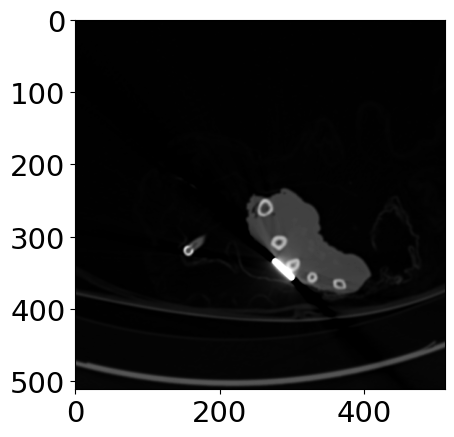

In [13]:
plt.imshow(image,cmap='gray')

In [ ]:
# Visualize data
sc = 'H1'
image_list = glob.glob(f"/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/Data/{sc}/BonyGeometry/DICOMs/CT/*.IMA")

cols = 4
rows = 2
fig, axs = plt.subplots(rows, cols,
                        figsize=(30, 20))
for r in range(rows):
    for c in range(cols):
        image = imageio.v2.imread(image_list[r*4+c])
        normalized = cv2.normalize(
                    image, None, 
                    alpha=0, beta=255, 
                    norm_type=cv2.NORM_MINMAX)
        axs[r, c].imshow(normalized, cmap='gray')
        axs[r, c].axes.get_xaxis().set_visible(False)
        axs[r, c].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
plt.tight_layout() 

fig.savefig('CT_images.pdf', dpi=300)

In [ ]:
old_grades['J10'] = 1

In [ ]:
sorted(collections.Counter([old_grades[sc] for sc in sample_codes]))

#### Count Class sizes

In [ ]:
combs = ['static', 'kinematic', 'image', 'kinematic+static', 'image+static', 'image+kinematic', 'all']
for i, sc_list in enumerate([list(set(static_data.keys())), 
                list(set(kinematic_data.keys())),
                list(set(image_sc)),
                list(set(kinematic_data.keys()) & set(static_data.keys())),
                list(set(image_sc) & set(static_data.keys())),
                list(set(image_sc) & set(kinematic_data.keys())),
                list(set(image_sc) & set(static_data.keys()) & set(kinematic_data.keys()))]):
    print(combs[i])
    print(f'#samples: {len(sc_list)}')
    old_count = collections.Counter([grades['old'][sc] for sc in sc_list])
    new_count = collections.Counter([grades['new'][sc] for sc in sc_list])
    print(f'class size (old grading): {[old_count.get(i, 0) for i in range(5)]}')
    print(f'class size (new grading): {[new_count.get(i, 0) for i in range(3)]}')
    print('\n')